# TMY to Power Tutorial

## PVLIB toolbox

Most of the code below is from the tmy_to_power notebook from the pvlib git repo.

The original tutorial uses TMY data to obtain AC power using the SAPM (Sandia PV Model). We will use it to predict production from solar photovoltaic panels with random weather inputs. 

Table of contents:
1. [Setup](#Setup)
2. [Load TMY data](#Load-TMY-data)
2. [Calculate modeling intermediates](#Calculate-modeling-intermediates)
2. [DC power using SAPM](#DC-power-using-SAPM)
2. [AC power using SAPM](#AC-power-using-SAPM)


### Notes

This tutorial has been tested against the following package versions:
* pvlib 0.3.0
* Python 2.7.10
* IPython 3.2
* pandas 0.16.2

It should work with other Python and Pandas versions. It requires pvlib >= 0.3.0 and IPython >= 3.0.

Original Authors:
* Will Holmgren (@wholmgren), University of Arizona, July 2015, March 2016.
* Rob Andrews (@Calama-Consulting), Heliolytics, June 2014

## Setup

These are just your standard interactive scientific python imports that you'll get very used to using.

In [1]:
# built-in python modules
import os
import inspect

# scientific python add-ons
import numpy as np
import pandas as pd

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib as mpl
# seaborn makes your plots look better
try:
    import seaborn as sns
    sns.set(rc={"figure.figsize": (12, 6)})
    sns.set_color_codes()
except ImportError:
    print('We suggest you install seaborn using conda or pip and rerun this cell')

# Import the pvlib library
import pvlib

# Import the file input-output module.
import wfileio as wf

## Load TMY data

pvlib comes with a couple of TMY files, and we'll use one of them for simplicity. You could also load a file from disk, or specify a url. See this NREL website for a list of TMY files:

http://rredc.nrel.gov/solar/old_data/nsrdb/1991-2005/tmy3/by_state_and_city.html

In [3]:
# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# Path to a data file
path_epw_ddn = '../India_Dehradun/IND_UT_Dehradun.421110_ISHRAE2014.epw'

# The small program get_weather stores data from the incoming weather
# file as a dataframe.
tmy, locdata, header = wf.get_weather('ddn', path_epw_ddn)
tmy.index.name = 'Time'

# TMY data seems to be given as hourly data with time stamp at the end
# shift the index 30 Minutes back for calculation of sun positions
# tmy_data = tmy_data.shift(freq='-30Min')

Found multiple years in file name, assigning 2223.
[2002 2003 2005 2006 1996 2001]


The file handling above looks complicated because we're trying to account for the many different ways that people will run this notebook on their systems. You can just put a simple string path into the ``readtmy3`` function if you know where the file is.

Let's look at the imported version of the TMY file.

In [5]:
tmy.head()

,year,month,day,hour,minute,qualflags,tdb,tdp,rh,atmpr,...,tsky,osky,vis,chgt,pwo,pwc,pwt,aopt,sdpt,slast
Time,,,,,,,,,,,,,,,,,,,,,
2223-01-01 00:00:00,2223,1,1,1,0.0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9,6.7,4.7,87.0,94000.0,...,0.0,0.0,2.0,77777.0,9.0,999999999.0,129.0,0.0,0.0,88.0
2223-01-01 01:00:00,2223,1,1,2,0.0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9,6.7,4.2,84.0,94000.0,...,0.0,0.0,2.0,77777.0,9.0,999999999.0,120.0,0.0,0.0,88.0
2223-01-01 02:00:00,2223,1,1,3,0.0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9,6.1,3.7,85.0,94000.0,...,0.0,0.0,2.0,77777.0,9.0,999999999.0,120.0,0.0,0.0,88.0
2223-01-01 03:00:00,2223,1,1,4,0.0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9,6.1,3.8,85.0,94000.0,...,0.0,0.0,2.0,77777.0,9.0,999999999.0,120.0,0.0,0.0,88.0
2223-01-01 04:00:00,2223,1,1,5,0.0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9,5.6,3.3,85.0,94000.0,...,0.0,0.0,2.0,77777.0,9.0,999999999.0,120.0,0.0,0.0,88.0


This is a ``pandas DataFrame`` object. It has a lot of great properties that are beyond the scope of our tutorials.

Plot the GHI data from the TMY file

Text(0, 0.5, 'Irradiance (W/m**2)')

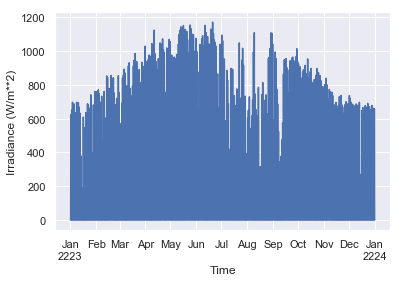

In [6]:
tmy['ghi'].plot()
plt.ylabel('Irradiance (W/m**2)')

## Calculate modeling intermediates

Before we can calculate power for all times in the TMY file, we will need to calculate:
* solar position 
* extra terrestrial radiation
* airmass
* angle of incidence
* POA sky and ground diffuse radiation
* cell and module temperatures

First, define some PV system parameters.

In [7]:
surface_tilt = 30
surface_azimuth = 180  # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = 0.2

# create pvlib Location object based on meta data
sand_point = pvlib.location.Location(locdata['lat'], locdata['long'], tz='Asia/Calcutta', 
                                     altitude=locdata['alt'], name='tmy_data')
print(sand_point)
print(type(sand_point.latitude))

Location: 
  name: tmy_data
  latitude: 30.320
  longitude: 78.030
  altitude: 682.0
  tz: Asia/Calcutta
<class 'str'>


### Solar position

Calculate the solar position for all times in the TMY file. 

The default solar position algorithm is based on Reda and Andreas (2004). Our implementation is pretty fast, but you can make it even faster if you install [``numba``](http://numba.pydata.org/#installing) and use add  ``method='nrel_numba'`` to the function call below.

In [9]:
solpos = pvlib.solarposition.get_solarposition(tmy.index, sand_point.latitude, sand_point.longitude)

solpos.plot()

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

The funny looking jump in the azimuth is just due to the coarse time sampling in the TMY file.

### DNI ET

Calculate extra terrestrial radiation. This is needed for many plane of array diffuse irradiance models.

In [ ]:
# the extraradiation function returns a simple numpy array
# instead of a nice pandas series. We will change this
# in a future version
dni_extra = pvlib.irradiance.extraradiation(tmy_data.index)
dni_extra = pd.Series(dni_extra, index=tmy_data.index)

dni_extra.plot()
plt.ylabel('Extra terrestrial radiation (W/m**2)')

### Airmass

Calculate airmass. Lots of model options here, see the ``atmosphere`` module tutorial for more details.

In [ ]:
airmass = pvlib.atmosphere.relativeairmass(solpos['apparent_zenith'])

plt.plot(airmass.iloc[0:72])
# airmass.plot()
plt.ylabel('Airmass')

The funny appearance is due to aliasing and setting invalid numbers equal to ``NaN``. Replot just a day or two and you'll see that the numbers are right.

### POA sky diffuse

Use the Hay Davies model to calculate the plane of array diffuse sky radiation. See the ``irradiance`` module tutorial for comparisons of different models.

In [ ]:
poa_sky_diffuse = pvlib.irradiance.haydavies(surface_tilt, surface_azimuth,
                                             tmy_data['dhi'], tmy_data['dni'], dni_extra,
                                             solpos['apparent_zenith'], solpos['azimuth'])

# There are some numerical errors in the sky diffuse calculation where the value spikes.
# We take the quantities that are larger than the ambient sky diffuse radiation and interpolate them. 
poa_sky_diffuse[poa_sky_diffuse > tmy_data.dhi] = np.NaN
poa_sky_diffuse = poa_sky_diffuse.interpolate(method='time')

poa_sky_diffuse.plot()
plt.ylabel('Irradiance (W/m**2)')

### POA ground diffuse

Calculate ground diffuse. We specified the albedo above. You could have also provided a string to the ``surface_type`` keyword argument.

In [ ]:
poa_ground_diffuse = pvlib.irradiance.grounddiffuse(surface_tilt, tmy_data['ghi'], albedo=albedo)

poa_ground_diffuse.plot()
plt.ylabel('Irradiance (W/m**2)')

### AOI

Calculate AOI

In [ ]:
aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth, solpos['apparent_zenith'], solpos['azimuth'])

aoi.plot()
plt.ylabel('Angle of incidence (deg)')

Note that AOI has values greater than 90 deg. This is ok.

### POA total

Calculate POA irradiance

In [ ]:
poa_irrad = pvlib.irradiance.globalinplane(aoi, tmy_data['dni'], poa_sky_diffuse, poa_ground_diffuse)

poa_irrad.plot()
plt.ylabel('Irradiance (W/m**2)')
plt.title('POA Irradiance')

### Cell and module temperature

Calculate pv cell and module temperature

In [ ]:
pvtemps = pvlib.pvsystem.sapm_celltemp(poa_irrad['poa_global'], tmy_data['wspd'], tmy_data['tdb'])

pvtemps.plot()
plt.ylabel('Temperature (degC)')

## DC power using SAPM

Get module data from the web.

In [ ]:
sandia_modules = pvlib.pvsystem.retrieve_sam(name='SandiaMod')

Choose a particular module

In [ ]:
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
sandia_module

Calculate the effective irradiance

In [ ]:
effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(poa_irrad.poa_direct, poa_irrad.poa_diffuse, airmass, aoi, sandia_module)

Run the SAPM using the parameters we calculated above.

In [ ]:
sapm_out = pvlib.pvsystem.sapm(effective_irradiance, pvtemps.temp_cell, sandia_module)
print(sapm_out.head())

sapm_out[['p_mp']].plot()
plt.ylabel('DC Power (W)')

## DC power using single diode

In [ ]:
cec_modules = pvlib.pvsystem.retrieve_sam(name='CECMod')
cec_module = cec_modules.Canadian_Solar_CS5P_220M

In [ ]:
photocurrent, saturation_current, resistance_series, resistance_shunt, nNsVth = (
    pvlib.pvsystem.calcparams_desoto(poa_irrad.poa_global,
                                 temp_cell=pvtemps['temp_cell'],
                                 alpha_isc=cec_module['alpha_sc'],
                                 module_parameters=cec_module,
                                 EgRef=1.121,
                                 dEgdT=-0.0002677) )

In [ ]:
single_diode_out = pvlib.pvsystem.singlediode(photocurrent, saturation_current,
                                              resistance_series, resistance_shunt, nNsVth)

In [ ]:
single_diode_out[['p_mp']].plot()
plt.ylabel('DC Power (W)')

## AC power using SAPM

Get the inverter database from the web

In [ ]:
sapm_inverters = pvlib.pvsystem.retrieve_sam('sandiainverter')

Choose a particular inverter

In [ ]:
sapm_inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']
sapm_inverter

In [ ]:
p_acs = pd.DataFrame()
p_acs['sapm'] = pvlib.pvsystem.snlinverter(sapm_out.v_mp, sapm_out.p_mp, sapm_inverter)
p_acs['sd'] = pvlib.pvsystem.snlinverter(single_diode_out.v_mp, single_diode_out.p_mp, sapm_inverter)

mask = p_acs['sapm'] < 0
p_acs.loc[mask, 'sapm'] = 0

mask = p_acs['sd'] < 0
p_acs.loc[mask, 'sd'] = 0

p_acs.plot()
plt.ylabel('AC Power (W)')

In [ ]:
diff = p_acs['sapm'] - p_acs['sd']
diff.plot()
plt.ylabel('SAPM - SD Power (W)')

Plot just a few days.

In [ ]:
p_acs['2017-07-05':'2017-07-06'].plot()

Some statistics on the AC power

In [ ]:
p_acs.describe()

In [ ]:
p_acs.sum()

In [ ]:
# create data for a y=x line
p_ac_max = p_acs.max().max()
yxline = np.arange(0, p_ac_max)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, aspect='equal')
sc = ax.scatter(p_acs['sd'], p_acs['sapm'], c=poa_irrad.poa_global, alpha=1, cmap=mpl.cm.YlGnBu_r)  
ax.plot(yxline, yxline, 'r', linewidth=3)
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.set_xlabel('Single Diode model')
ax.set_ylabel('Sandia model')
fig.colorbar(sc, label='POA Global (W/m**2)')

We can change the value of color value ``c`` to see the sensitivity of model accuracy to measured meterological conditions. It can be useful to define a simple plotting function for this kind of exploratory analysis.

In [ ]:
def sapm_sd_scatter(c_data, label=None, **kwargs):
    """Display a scatter plot of SAPM p_ac vs. single diode p_ac.
    
    You need to re-execute this cell if you re-run the p_ac calculation.
    
    Parameters
    ----------
    c_data : array-like
        Determines the color of each point on the scatter plot.
        Must be same length as p_acs.
        
    kwargs passed to ``scatter``.
    
    Returns
    -------
    tuple of fig, ax objects
    """
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, aspect='equal')
    sc = ax.scatter(p_acs['sd'], p_acs['sapm'], c=c_data, alpha=1, cmap=mpl.cm.YlGnBu_r, **kwargs)  
    ax.plot(yxline, yxline, 'r', linewidth=3)
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel('Single diode model power (W)')
    ax.set_ylabel('Sandia model power (W)')
    fig.colorbar(sc, label='{}'.format(label), shrink=0.75)
    
    return fig, ax

In [ ]:
sapm_sd_scatter(tmy_data.tdb, label='Temperature (deg C)')

In [ ]:
sapm_sd_scatter(tmy_data.dni, label='DNI (W/m**2)')

In [ ]:
# sapm_sd_scatter(tmy_data.AOD, label='AOD')

In [ ]:
sapm_sd_scatter(tmy_data.wspd, label='Wind speed', vmax=10)

Notice the use of the ``vmax`` keyword argument in the above example. The ``**kwargs`` pattern allows us to easily pass non-specified arguments to nested functions.

In [ ]:
def sapm_other_scatter(c_data, x_data, clabel=None, xlabel=None, aspect_equal=False, **kwargs):
    """Display a scatter plot of SAPM p_ac vs. something else.
    
    You need to re-execute this cell if you re-run the p_ac calculation.
    
    Parameters
    ----------
    c_data : array-like
        Determines the color of each point on the scatter plot.
        Must be same length as p_acs.
    x_data : array-like
        
    kwargs passed to ``scatter``.
    
    Returns
    -------
    tuple of fig, ax objects
    """
    
    fig = plt.figure(figsize=(12,12))
    
    if aspect_equal:
        ax = fig.add_subplot(111, aspect='equal')
    else:
        ax = fig.add_subplot(111)
    sc = ax.scatter(x_data, p_acs['sapm'], c=c_data, alpha=1, cmap=mpl.cm.YlGnBu_r, **kwargs)  
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel('{}'.format(xlabel))
    ax.set_ylabel('Sandia model power (W)')
    fig.colorbar(sc, label='{}'.format(clabel), shrink=0.75)
    
    return fig, ax

In [ ]:
sapm_other_scatter(tmy_data.tdb, tmy_data.ghi, clabel='Temperature (deg C)', xlabel='GHI (W/m**2)')